# <span style="color:blue">PROJETO: Análise de Sentimentos - Pull Requests</span>

<b>O problema</b>: Um problema comum em NLP é a classificação de amostras de texto, isto é, dado um texto, alocar em uma categoria, ou medir um índice de afinidade para uma ou mais categorias. Um problema comum em grandes projetos de código aberto é determinar quando o comentário em um pull request é positivo ou negativo.

<b>O objetivo</b>: Construir um modelo para classificação de comentários de pull-requests, indicando se podem ser consideradas <b>positivas</b>, <b>negativas</b> ou <b>neutras</b>.

In [40]:
# Import das bibliotecas
# Utilitários
import pandas as pd
import numpy as np
import re
import string
import itertools

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# nltk
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


# Matplot and Seaborn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

[nltk_data] Downloading package stopwords to /home/manoel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
ENCODING = "ISO-8859-1"
# Colunas que devem ser removidas
COLUMNS_DROP = ["airline_sentiment_confidence", "negativereason", "negativereason_confidence", "airline",
                "airline_sentiment_gold", "name", "negativereason_gold", "retweet_count", "tweet_coord",
                "tweet_created", "tweet_location", "user_timezone"]

In [3]:
df_data = pd.read_csv('trainer/data/Tweets.csv')

In [4]:
df_data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [6]:
def get_color_labels(df):
    color_map = []
    color_map.append(
        {
            'key': 'Negative',
            'color': '#FF0000',
            'count': len(df[df['airline_sentiment']=='Negative'])
        }
    )
    color_map.append(
        {
            'key': 'Positive',
            'color': '#00FF00',
            'count': len(df[df['airline_sentiment']=='Positive'])
        }
    )
    color_map.append(
        {
            'key': 'Neutral',
            'color': '#FFFF00',
            'count': len(df[df['airline_sentiment']=='Neutral'])
        }
    )

    color_map = sorted(color_map, key=lambda k: k['count'], reverse=True)
    color_labels = [x['color'] for x in color_map]

    return color_labels

In [7]:
def plot_statistics(df, title):
    rgb_values = get_color_labels(df)
    
    plt.figure(figsize=(16, 7))
    plt.xticks(fontsize=18, fontweight='bold')
    ax = sns.countplot(data=df, x = 'airline_sentiment', order = df['airline_sentiment'].value_counts().index,
                       palette=rgb_values)
    ax.set_xlabel('Class', fontsize=22, fontweight='bold')
    ax.set_ylabel('Total', fontsize=22, fontweight='bold')
    ax.set_title(title, fontsize=25)
    
    for rect in ax.patches:
        height = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., height+.1, height,
                ha='center', va='bottom', size=20, weight='bold')
    
    ax.margins(y=0.09)
    plt.show()

## Análise dos dados

Pode ser observado que existe um desbalanceamento dos dados na classe negative, isso pode gerar um viés para o modelo. Poderia ser aplicada alguma técnica de downsampling ou oversampling para balancear o dataset, contudo nesse caso em específico não será aplicada nenhuma técnica pois o objetivo aqui é mostrar o processo do treinamento e "produtização" de um modelo de machine learning.

----------------------------------------------------------------

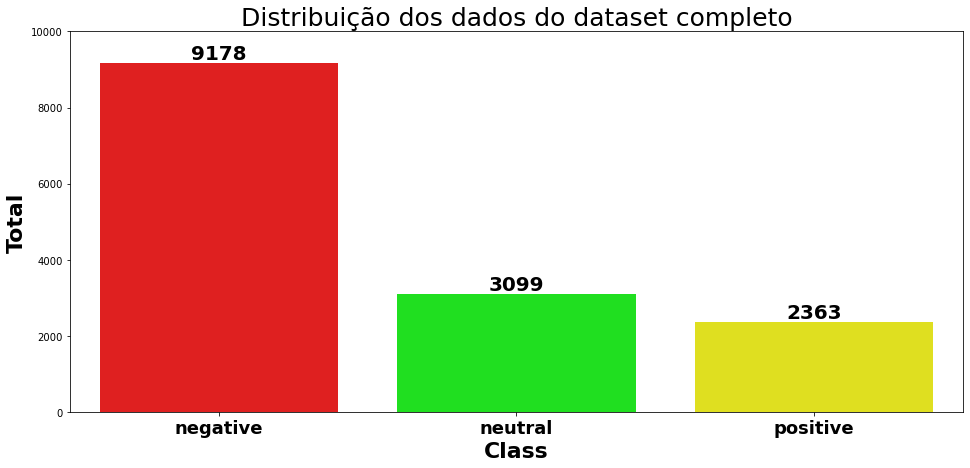

In [8]:
plot_statistics(df_data, "Distribuição dos dados do dataset completo")

## Preparação dos dados
Para o treinamento do modelo serão realizadas algumas etapas descritas abaixo:

* Codificar os labels que estão como texto para números usando a regra: 0 - negative, 1 - positive e 2 - neutral;
* Remover as colunas que não serão usadas no treinamento do modelo;
* Separar o conjunto de dados em treino, validação e teste.
------------------------------------------------------------------

In [9]:
def decode_sentiment(label):
    decode_map = {"negative": 0, "neutral": 1, "positive": 2}
    return decode_map[label]

In [10]:
%%time
df_data.airline_sentiment = df_data.airline_sentiment.apply(lambda x: decode_sentiment(x))

CPU times: user 10.5 ms, sys: 345 µs, total: 10.9 ms
Wall time: 10.5 ms


In [11]:
df_data.drop(COLUMNS_DROP, axis=1, inplace=True)

In [12]:
df_train, df_test = train_test_split(df_data, test_size=0.15, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.15, random_state=42)

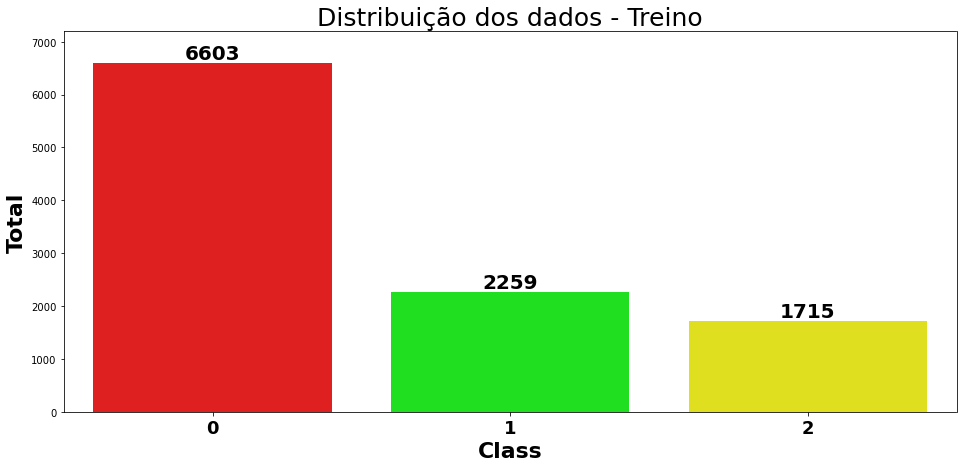

In [13]:
plot_statistics(df_train, "Distribuição dos dados - Treino")

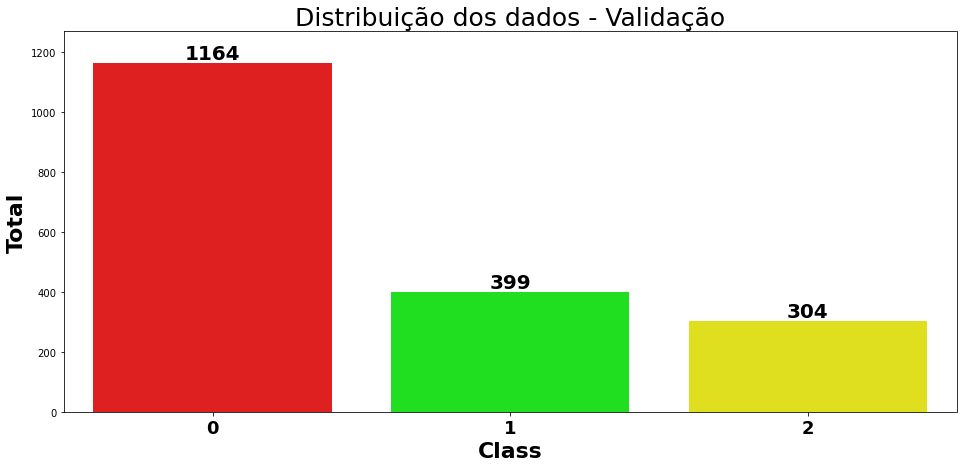

In [14]:
plot_statistics(df_val, "Distribuição dos dados - Validação")

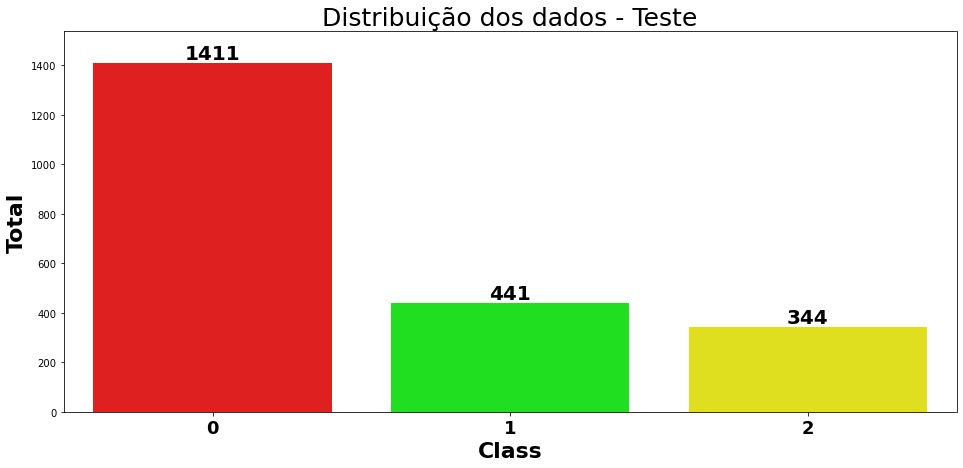

In [15]:
plot_statistics(df_test, "Distribuição dos dados - Teste")

In [16]:
# df_train.to_csv("trainer/data/train.csv", index=None)
# df_val.to_csv("trainer/data/val.csv", index=None)
# df_test.to_csv("trainer/data/test.csv", index=None)

------------------------------------------
### Analise dos resultados
------------------------------------------

In [45]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [19]:
df_results = pd.read_csv('results.csv')
df_test = pd.read_csv('trainer/data/test.csv')

In [18]:
df_results.head()

,y_texts,y_pred_probs,y_pred
0,southwestair youre early frontrunner best airline,[-3.182425 -1.5364244 5.291989 ],2
1,usairways flt ewr cancelled flightled yet flts...,[ 3.7698495 -0.7649798 -3.068239 ],0
2,jetblue going bdl dca flights yesterday today ...,[ 5.5292516 -2.6567204 -2.7386208],0
3,jetblue depart washington dc,[-1.6731405 5.2363424 -3.5379908],1
4,jetblue probably find ticket,[-0.50988793 4.222588 -3.425069 ],1


In [20]:
y_test = df_test['airline_sentiment'].values
y_pred = df_results['y_pred'].values

In [23]:
target_names = ['Negative', 'Neutral', 'Positive']
report = classification_report(y_test, y_pred, target_names=target_names, digits=4)
print(report)

              precision    recall  f1-score   support

    Negative     0.8877    0.9022    0.8949      1411
     Neutral     0.6592    0.6009    0.6287       441
    Positive     0.7556    0.7907    0.7727       344

    accuracy                         0.8242      2196
   macro avg     0.7675    0.7646    0.7654      2196
weighted avg     0.8211    0.8242    0.8223      2196



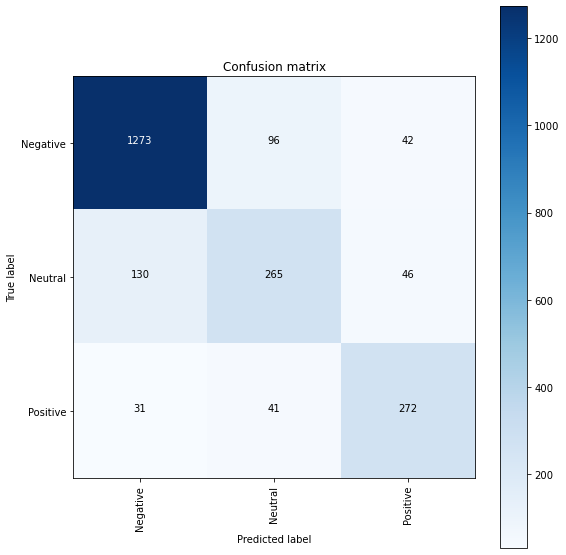

In [46]:
confusion_mtx = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confusion_mtx, target_names)

* A acurácia do modelo foi de 82.42%, o que já é um bom resultado para uma transferência de aprendizado.
* A classe que tem menor assertividade é a Neutral e para melhorar isso talvez balancear o dataset seja uma saída.